In [22]:
import os
import asyncio
from dotenv import load_dotenv
from fastapi import FastAPI
from fastapi.responses import StreamingResponse
from pydantic import BaseModel
from langchain_mistralai import ChatMistralAI
from langchain_core.prompts import PromptTemplate
# from langgraph.checkpoint import MemorySaver
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display


In [23]:

# Load API key
load_dotenv()
api_key = os.getenv("MISTRAL_API_KEY")

# Initialize FastAPI
# app = FastAPI()


In [24]:
# Initialize models
entrepreneur_llm = ChatMistralAI(
    model="mistral-small-latest", temperature=0, max_retries=2, streaming=True
)

dragon_llm = ChatMistralAI(
    model="mistral-small-latest", temperature=0, max_retries=2, streaming=True
)

In [25]:
# Define prompts
entrepreneur_prompt = PromptTemplate.from_template(
    """You are an ambitious entrepreneur pitching a startup idea on Dragon's Den.
    
    Your task:
    1. Identify a major problem in the {industry} industry.
    2. Propose an innovative business idea that solves this problem.
    3. Explain your unique selling point (USP) – what makes your idea different?
    4. Describe your business model – how will you generate revenue?
    
    Be compelling and persuasive. Keep your pitch under 100 words.

    Your pitch:"""
)

dragon_prompt = PromptTemplate.from_template(
    """You are a seasoned investor on Dragon's Den, evaluating a startup pitch. 
    
    Your task:
    1. Analyze the business idea: {pitch}
    2. Identify the strengths – what makes it promising?
    3. Highlight potential risks or weaknesses.
    4. Assess market potential – is there demand? Who are the competitors?
    5. Suggest improvements or alternative business strategies.

    Provide your analysis in a professional but engaging way, like a real Dragon's Den judge. Keep your response under 200 words.

    Your response:"""
)

response_prompt = PromptTemplate.from_template(
    """You are the entrepreneur responding to an investor's feedback. Address the points raised in their evaluation and explain how your business will overcome challenges. Keep your response under 100 words.

    Investor's feedback: {evaluation}

    Your response:"""
)

In [26]:
# AI generated pitch for testing
def generate_demo_pitch(industry: str):
    entrepreneur_chain = entrepreneur_prompt | entrepreneur_llm
    response = entrepreneur_chain.invoke({"industry": industry})
    return response

template_industry = "fintech"

pitch = generate_demo_pitch(template_industry)

In [27]:
print(pitch.content)
# print(pitch.pretty_print())

Ladies and Gentlemen, Dragons,

The fintech industry is booming, but it's also riddled with complexity and high fees. The major problem? **Financial services are still too complicated and expensive for the average person.**

Introducing **FinEase**, a revolutionary fintech platform that simplifies financial management and reduces costs. Our unique selling point? **AI-driven personal finance management** that automates budgeting, saving, and investing, all in one place.

Our business model is subscription-based, with tiered plans starting at just $5/month. We also earn a small commission on investments made through our platform. With FinEase, everyone can achieve financial freedom without the hassle.

Join us in making finance easy and affordable for all.


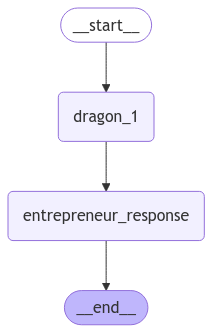

In [43]:
# Define state for conversation tracking
class ConversationState(MessagesState):
    industry: str = template_industry
    pitch: str
    summary: str

# Initialize memory for storing conversation state
# memory = MemorySaver()

# Define LangGraph workflow
builder = StateGraph(ConversationState)

# Step 1: Generate entrepreneur's pitch
# def generate_pitch(state: ConversationState):
#     entrepreneur_chain = entrepreneur_prompt | entrepreneur_llm
#     response = entrepreneur_chain.invoke({"industry": state.industry})
#     state.pitch = response.content
#     return state

# Step 2: Investor evaluates pitch
def evaluate_pitch(state: ConversationState):
    # print(state["messages"])
    pitch = state["messages"][-1].content
    state["pitch"] = pitch
    dragon_chain = dragon_prompt | dragon_llm
    response = dragon_chain.invoke({"pitch": pitch})
    # state["evaluation"] = response.content
    return {"messages": response}

def entrepreneur_response(state: ConversationState):
    evaluation = state["messages"][-1].content
    response_chain = response_prompt | entrepreneur_llm
    response = response_chain.invoke({"evaluation": evaluation})
    # state["response"] = response.content
    return {"messages": response}

# @graph.node()
# async def entrepreneur_response(state: PitchState):
#     """Entrepreneur responds to the investor's feedback."""
#     response_chain = response_prompt | entrepreneur_llm
#     result = await response_chain.ainvoke({"evaluation": state.evaluation})
#     state.response = result.content
#     return state

# Add nodes to the graph
# graph.add_node("entrepreneur", RunnableLambda(generate_pitch))
# graph.add_node("investor", RunnableLambda(evaluate_pitch))
# graph.add_node("entrepreneur_response", RunnableLambda(entrepreneur_response))

# builder.add_node("entrepreneur", generate_pitch)
builder.add_node("dragon_1", evaluate_pitch)
builder.add_node("entrepreneur_response", entrepreneur_response)

# Define edges (execution order)
# builder.add_edge(START, "entrepreneur")
builder.add_edge(START, "dragon_1")
# builder.add_edge("entrepreneur", "investor")  # Entrepreneur -> Investor
builder.add_edge("dragon_1", "entrepreneur_response")  # Entrepreneur -> Investor
builder.add_edge("entrepreneur_response", END)

# Compile the graph
# app_graph = graph.compile(checkpointer=memory)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))



In [41]:
input_message = HumanMessage(content=pitch.content)
for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

# input_message = {"role": "user", "content": "what's my name?"}
# for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Ladies and Gentlemen, Dragons,

The fintech industry is booming, but it's also riddled with complexity and high fees. The major problem? **Financial services are still too complicated and expensive for the average person.**

Introducing **FinEase**, a revolutionary fintech platform that simplifies financial management and reduces costs. Our unique selling point? **AI-driven personal finance management** that automates budgeting, saving, and investing, all in one place.

Our business model is subscription-based, with tiered plans starting at just $5/month. We also earn a small commission on investments made through our platform. With FinEase, everyone can achieve financial freedom without the hassle.

Join us in making finance easy and affordable for all.
================================== Ai Message ==================================

Ladies and Gentlemen, Dragons,

FinEase presents an intriguing proposit